In [53]:
import gymnasium as gym
import gym_trading_env
import yfinance as yf
from pprint import pprint
import matplotlib.pyplot as plt
from stable_baselines3 import PPO, A2C, DQN,HER
import pandas as pd
from preprocessors import FeatureEngineer
from yahoodownloader import YahooDownloader
import numpy as np
# from env import TradingEnv
%matplotlib inline

In [54]:
stock_name = "MSFT"
start_date_train = "2020-01-01"
end_date_train = "2023-01-01"
start_date_test = "2023-01-01"
end_date_test = "2023-04-01"

timesteps = 1e4

In [55]:
def get_data(stock_name, start_date, end_date):
    df = yf.download(stock_name, start=start_date, end=end_date)
    df = df.reset_index()
    df.columns = [x.lower() for x in df.columns]
    df = df.dropna()
    return df

In [56]:
DOW_30_TICKER = [
    "AXP",
    "AMGN",
    "AAPL",
    "BA",
    "CAT",
    "CSCO",
    "CVX",
    "GS",
    "HD",
    "HON",
    "IBM",
    "INTC",
    "JNJ",
    "KO",
    "JPM",
    "MCD",
    "MMM",
    "MRK",
    "MSFT",
    "NKE",
    "PG",
    "TRV",
    "UNH",
    "CRM",
    "VZ",
    "V",
    "WBA",
    "WMT",
    "DIS",
    "DOW",
]

In [57]:
df_train = YahooDownloader(start_date=start_date_train,
                     end_date = end_date_train,
                     ticker_list = [stock_name]).fetch_data()
df_test = YahooDownloader(start_date=start_date_test,
                        end_date = end_date_test,
                        ticker_list = [stock_name]).fetch_data()

[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (756, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (62, 8)


In [58]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30',
            'close_30_sma',
            'close_60_sma',
            'close_30_ema',
            'close_60_ema',
            'close_180_ema',
            'boll',
            'boll_ub',
            'boll_lb']


In [59]:
def add_indicators(df):
    fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = False)
    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    return processed

In [60]:
df_train = add_indicators(df_train)
df_test = add_indicators(df_test)

Successfully added technical indicators
Successfully added technical indicators


In [62]:
num_actions = int(1e3 + 1)
positions = np.linspace(0, 1, num_actions).tolist()
env_train = gym.make('TradingEnv', df=df_train, positions = positions,portfolio_initial_value = 100000)
env_test = gym.make('TradingEnv', df=df_test, positions = positions,portfolio_initial_value = 100000)

# env_train = TradingEnv(df_train)
# env_test = TradingEnv(df_test)

In [63]:
def simulate(env,models = None):
    observation, info = env.reset()
    truncated, done = False, False
    history = []
    while not done:
        action = None
        if models:
            action = 0
            if(type(models) != list):
                models = [models]
            for model in models:
                action += model.predict(observation)[0]
            action /= len(models)
            action = int(action)
        else:
            action = env.action_space.sample()
        observation, reward, done, truncated, info = env.step(action)
        if truncated:
            break
        history.append(info)
    return history

In [64]:
def plot_history(history):
    df = pd.DataFrame(history)
    actions = df['real_position']
    valuation = df['portfolio_valuation']
    dates = df['date']
    fig, ax1 = plt.subplots(figsize=(15, 8))
    ax1.plot(dates, valuation)
    ax1.scatter(dates, valuation, c=actions)
    ax1.set_xlabel('date')
    ax1.set_ylabel('valuation')
    fig.tight_layout()
    plt.show()

Market Return : 53.58%   |   Portfolio Return : 30.36%   |   


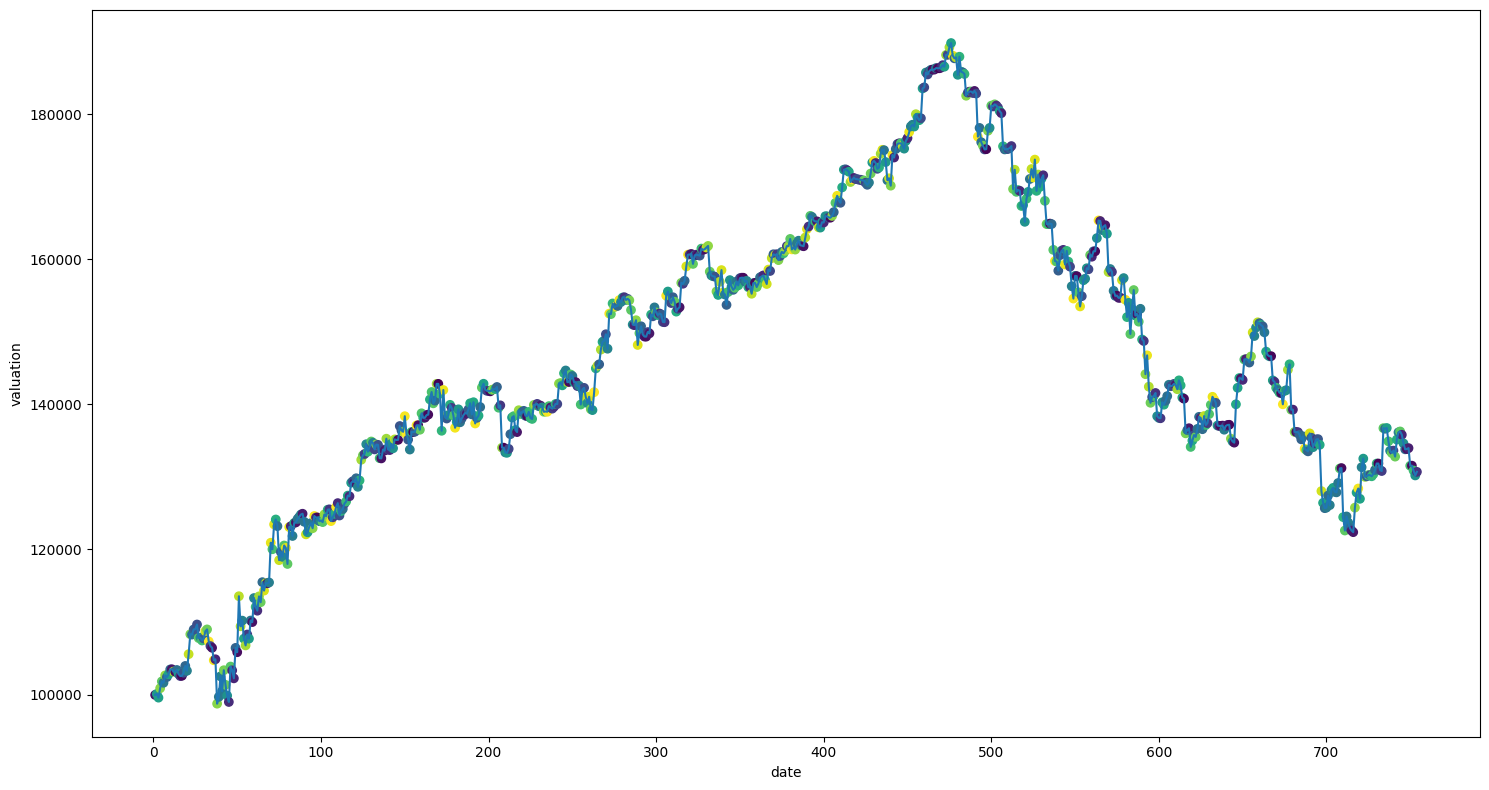

In [65]:
history = simulate(env_train)
plot_history(history)

In [66]:
model = PPO('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Market Return : 53.58%   |   Portfolio Return : 21.92%   |   
Market Return : 53.58%   |   Portfolio Return : 32.97%   |   
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 755      |
|    ep_rew_mean     | 0.242    |
| time/              |          |
|    fps             | 2442     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
Market Return : 53.58%   |   Portfolio Return : 40.77%   |   
Market Return : 53.58%   |   Portfolio Return : 30.69%   |   
Market Return : 53.58%   |   Portfolio Return : -14.20%   |   
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 755         |
|    ep_rew_mean          | 0.188       |
| time/                   |             |
|    fps                  | 1759        |
|  

Market Return : 53.58%   |   Portfolio Return :  6.01%   |   


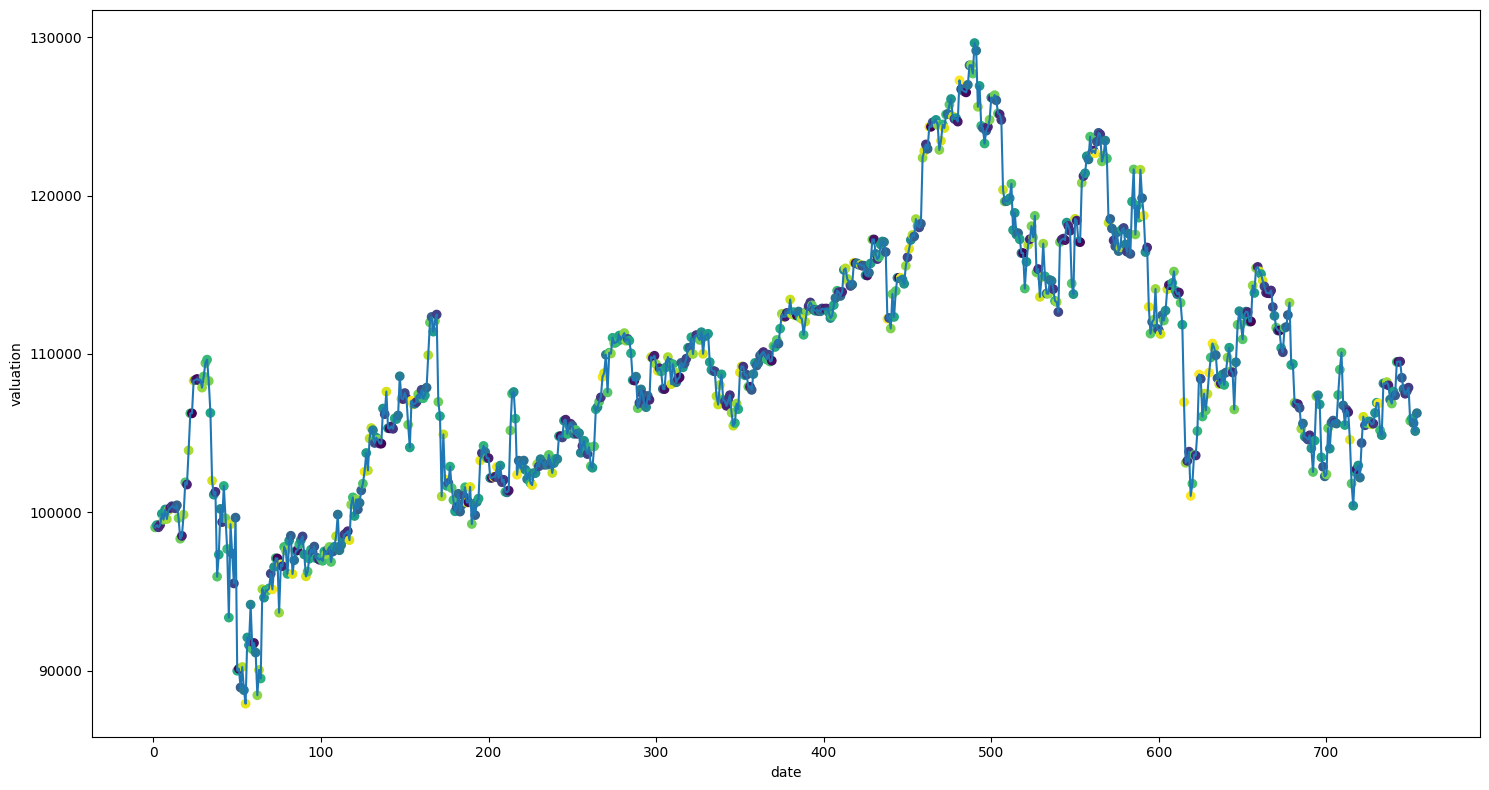

In [67]:
history = simulate(env_train, model)
plot_history(history)

Market Return : 20.64%   |   Portfolio Return :  3.78%   |   


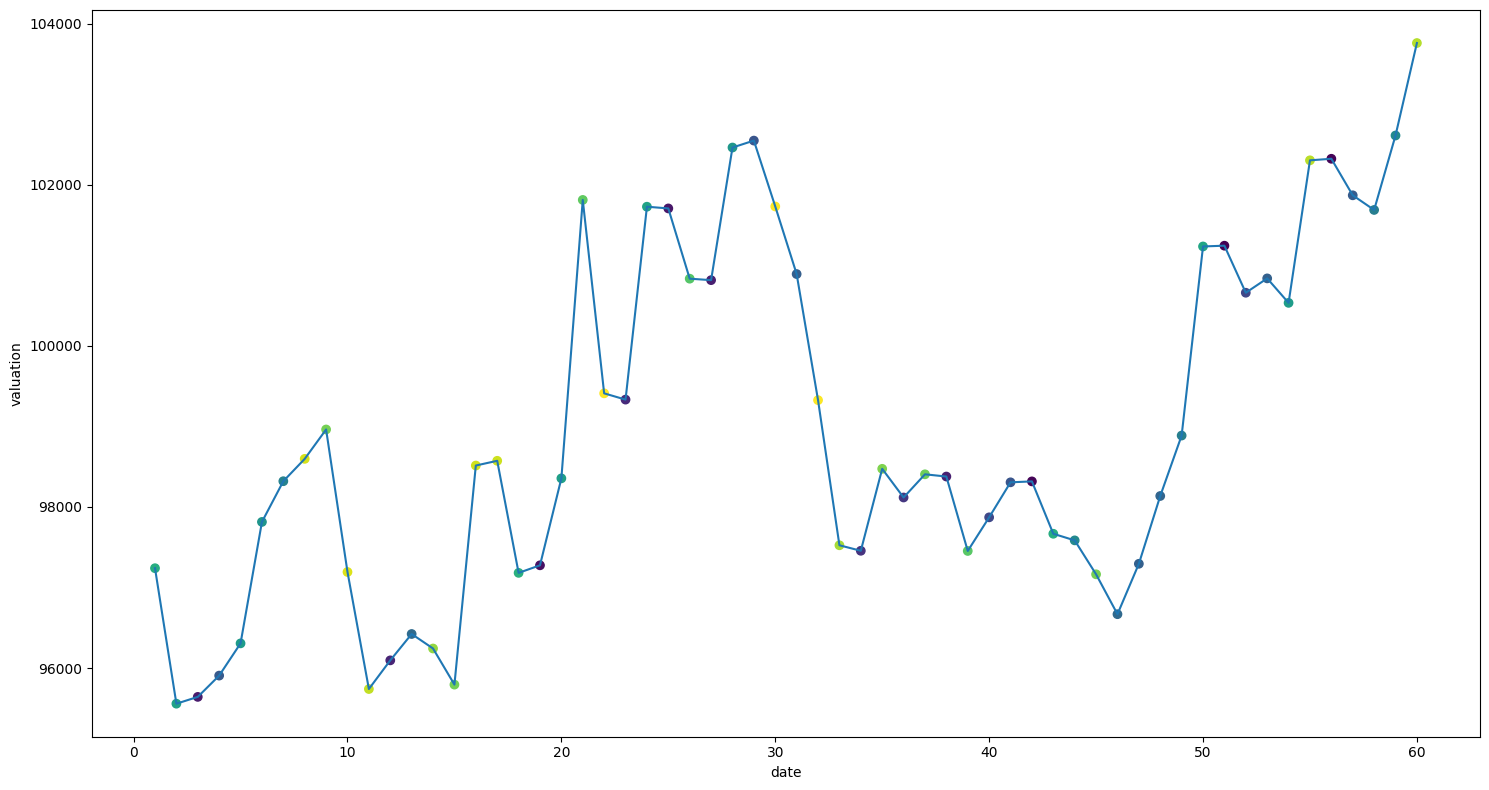

In [68]:
history = simulate(env_test, model)
plot_history(history)

In [69]:
a2c_model = A2C('MlpPolicy', env_train, verbose=1)
ppo_model = PPO('MlpPolicy', env_train, verbose=1)
dqn_model = DQN('MlpPolicy', env_train, verbose=1)

models = [a2c_model, ppo_model]
for model in models:
    model.learn(total_timesteps=timesteps)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 1052     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -6.91    |
|    explained_variance | -3.17    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0503  |
|    value_loss         | 0.000419 |
------------------------------------
Market Return : 53.58%   |   Portfolio Return : 11.77%   |   
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 755      |
|    ep_rew_mean        | 0

Market Return : 53.58%   |   Portfolio Return : 41.54%   |   


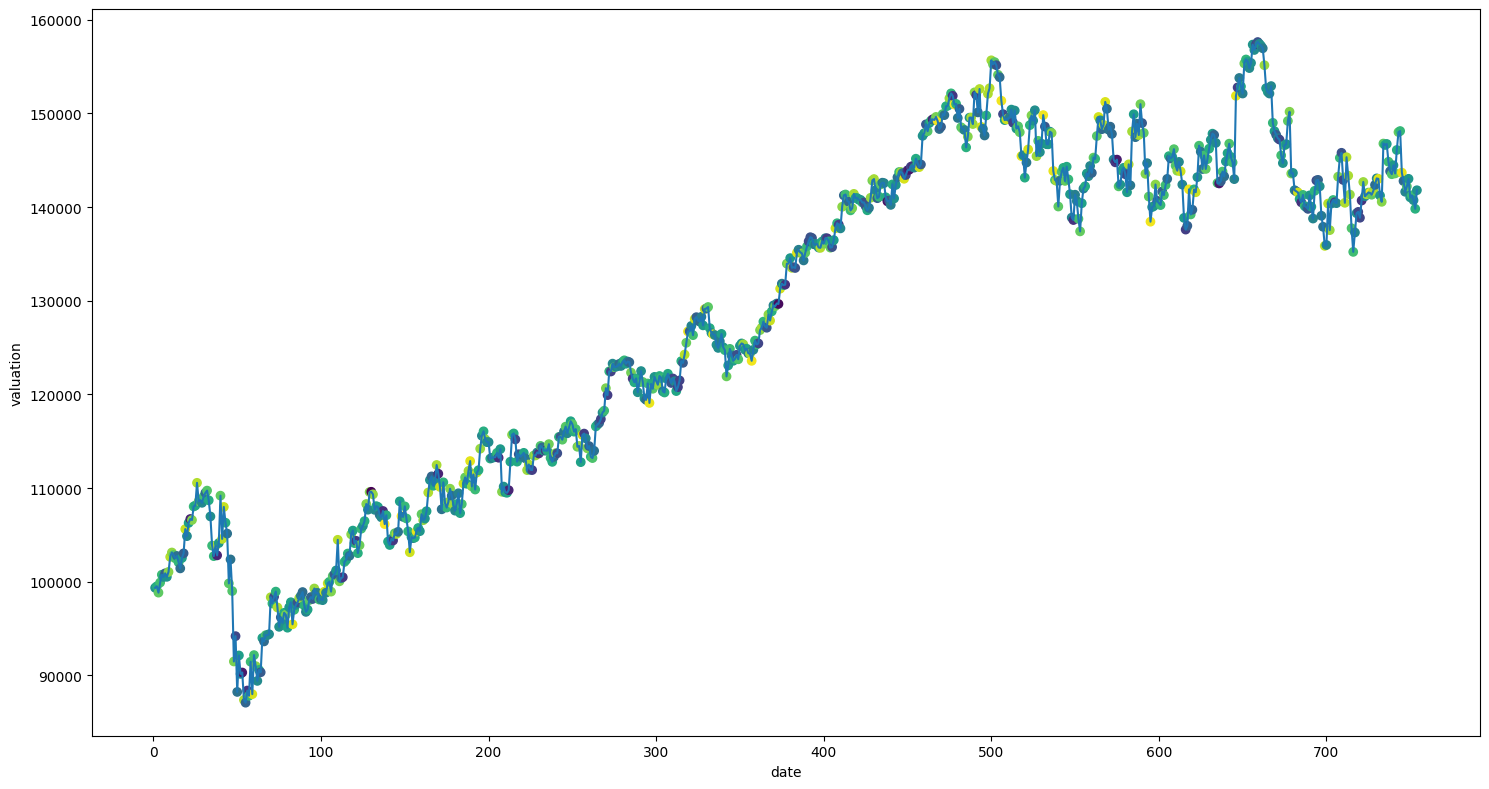

In [70]:
history = simulate(env_train, models)
plot_history(history)

Market Return : 20.64%   |   Portfolio Return : 10.08%   |   


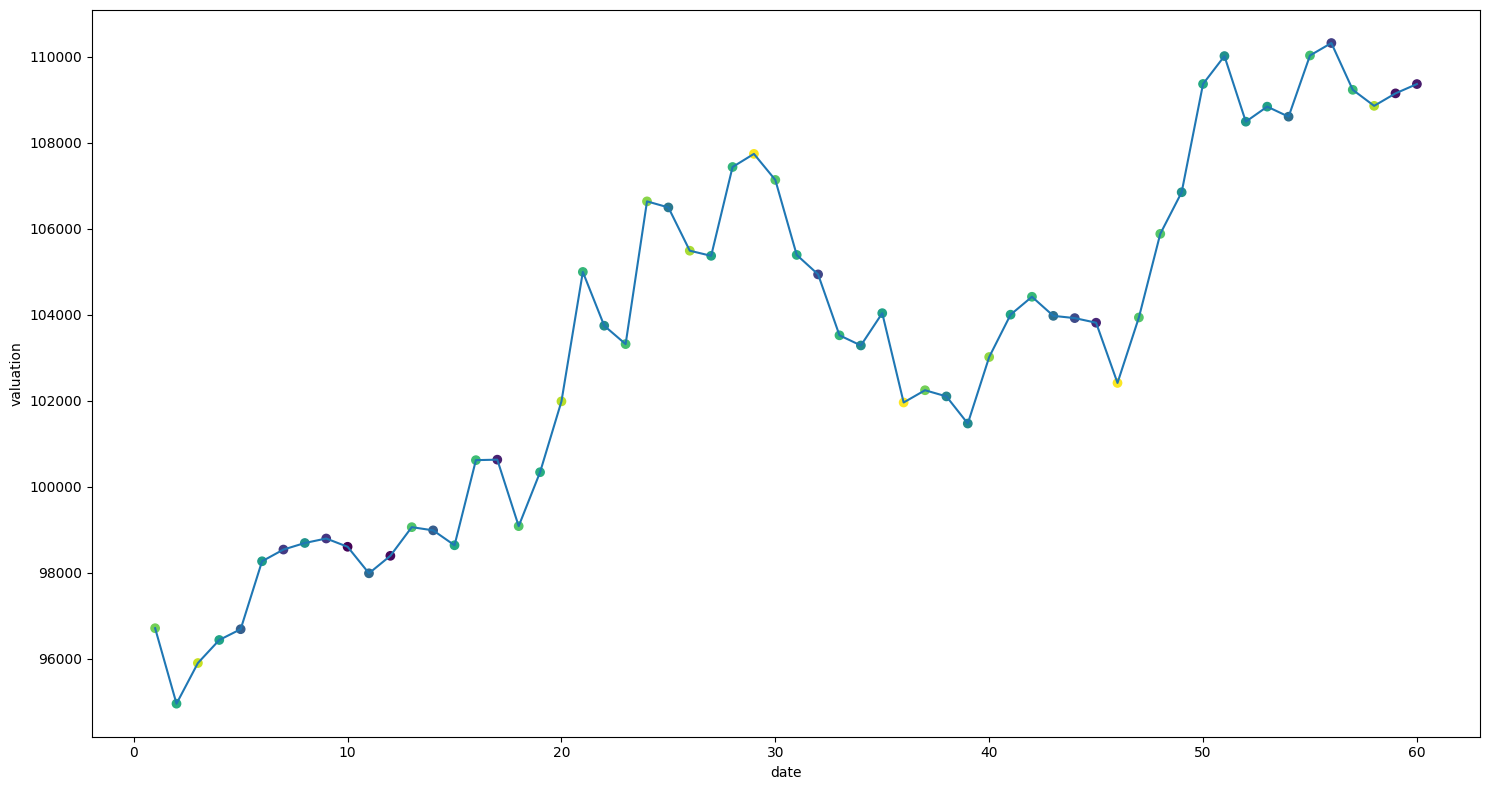

In [71]:
history = simulate(env_test, models)
plot_history(history)